# Parametric shape optimization with differentiable FEM simulation


## Setup

In [ ]:
# Install additional requirements for this notebook
%pip install -r requirements.txt -q --isolated

In [ ]:
import tesseract_core

tesseract_core.build_tesseract("sdf_fd", "latest")
tesseract_core.build_tesseract("pymapdl", "latest")
tesseract_core.build_tesseract("spaceclaim", "latest")
print("Tesseract built successfully.")

In [4]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_jax import apply_tesseract
from utils import MMAOptimizer, hex_grid, plot_grid, plot_grid_slice, plot_mesh

from tesseract_core import Tesseract

Before executing this cell, the grpc Ansys server and the spaceclaim tesseract should be both running on a machine with a known IP address and public ports. Look at `Readme.md` for specific instructions. Here we need to define the IP adress and ports of the relevant endpoints.

In [ ]:
# TODO: set the IP address of the Ansys machine
spaceclaim_host = "0.0.0.0"
mapdl_host = spaceclaim_host
# TODO: adjust the install path of Ansys SpaceClaim
spaceclaim_loc = "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe"

# TODO: set the relevant ports
spaceclaim_port = 442
mapdl_port = 443

spaceclaim_url = f"http://{spaceclaim_host}:{spaceclaim_port}"

In [6]:
design_tess = Tesseract.from_image("sdf_fd_tess")
design_tess.serve()

fem_tess = Tesseract.from_image("pymapdl_tess")
fem_tess.serve()

## Design Space

We start by settuping the relevant parameters and a few ICs for the optimization.

In [7]:
grid_fin_params = {
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

rng_key = jax.random.key(0)
grid_fins_rand = jax.random.uniform(rng_key, 16) * 2.0 * jnp.pi

grid_fins_grid = [
    0.84107417,
    5.44211113718,
    1.3466961,
    4.93648920718,
    1.7948966,
    4.48828870718,
    2.30051849,
    3.98266681718,
    0.19739674,
    2.94419591359,
    0.72972216,
    2.41187049359,
    6.08578856718,
    3.33898939359,
    5.55346314718,
    3.87131481359,
]

init_diffable_params_rnd = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_rand).flatten(),
    ]
).astype(jnp.float32)

init_diffable_params_grid = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_grid).flatten(),
    ]
).astype(jnp.float32)


non_diffable_params = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

In [ ]:
Nx, Ny, Nz = 100, 80, 3
Lx, Ly, Lz = 50, 40, 2


normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(
    params: jnp.ndarray, norms: jnp.ndarray, bias: jnp.ndarray
) -> jnp.ndarray:
    """Normalize parameters."""
    return params * norms + bias


def denormalize(
    params: jnp.ndarray, norms: jnp.ndarray, bias: jnp.ndarray
) -> jnp.ndarray:
    """Denormalize parameters."""
    return (params - bias) / norms


init_diffable_params_rnd = normalize(
    init_diffable_params_rnd, normalization_factors, normalization_bias
)

init_diffable_params_grid = normalize(
    init_diffable_params_grid, normalization_factors, normalization_bias
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_params,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        spaceclaim_loc,
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": {"type": "url", "ref": spaceclaim_url},
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

Lets obtain the randomized geometry from the design space.

In [9]:
design_out_rnd = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_rnd,
        **design_inputs,
    },
)
sdf_rnd = design_out_rnd["sdf"]
surface_mesh_rnd = design_out_rnd["mesh"]

num_vertices = surface_mesh_rnd["n_points"]
num_faces = surface_mesh_rnd["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_rnd["points"][:num_vertices]
faces = surface_mesh_rnd["faces"][:num_faces]

mesh_rnd = {
    "points": surface_mesh_rnd["points"][:num_vertices],
    "faces": surface_mesh_rnd["faces"][:num_faces],
}

Number of vertices: 222
Number of faces: 500


Using matplotlib and a helper function we can visualize the generated triangular mesh.

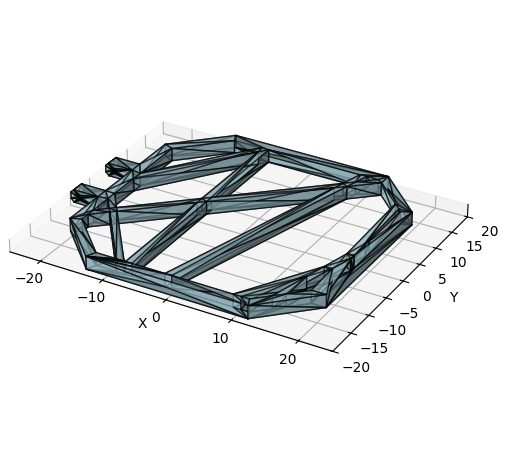

In [10]:
plot_mesh(mesh_rnd, [Lx, Ly, Lz], figsize=(8, 5))

And the corresponding signed distance field (SDF).

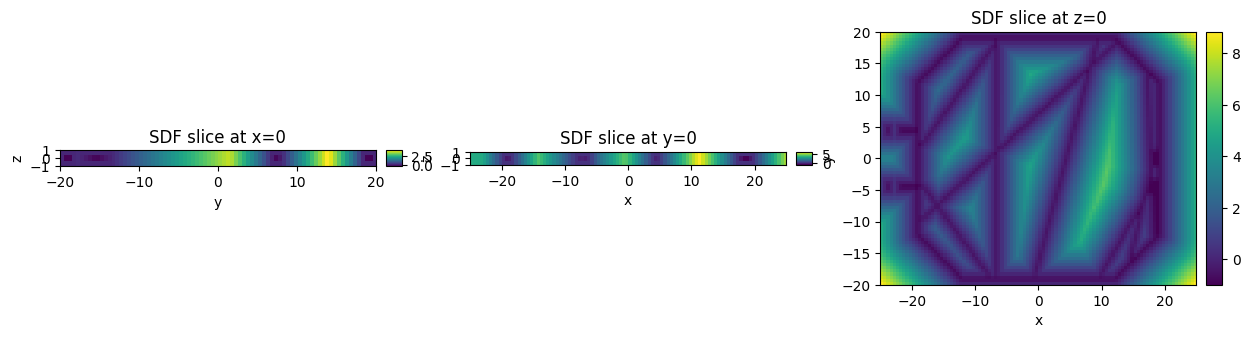

In [11]:
plot_grid(sdf_rnd, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

Lets repeat the same for the grid like initialization.

In [12]:
design_out_grid = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_grid,
        **design_inputs,
    },
)
sdf_grid = design_out_grid["sdf"]
surface_mesh_grid = design_out_grid["mesh"]

num_vertices = surface_mesh_grid["n_points"]
num_faces = surface_mesh_grid["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_rnd["points"][:num_vertices]
faces = surface_mesh_rnd["faces"][:num_faces]

mesh_grid = {
    "points": surface_mesh_grid["points"][:num_vertices],
    "faces": surface_mesh_grid["faces"][:num_faces],
}

Number of vertices: 304
Number of faces: 712


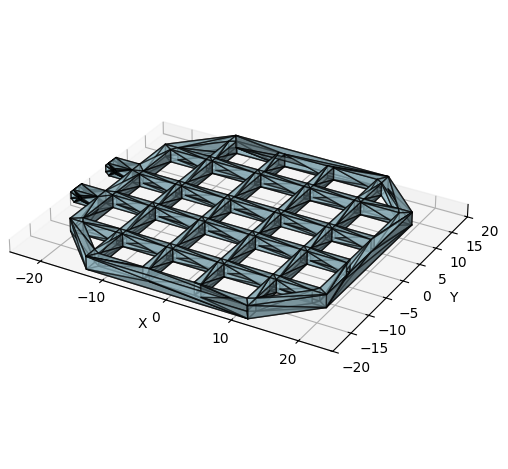

In [13]:
plot_mesh(mesh_grid, [Lx, Ly, Lz], figsize=(8, 5))

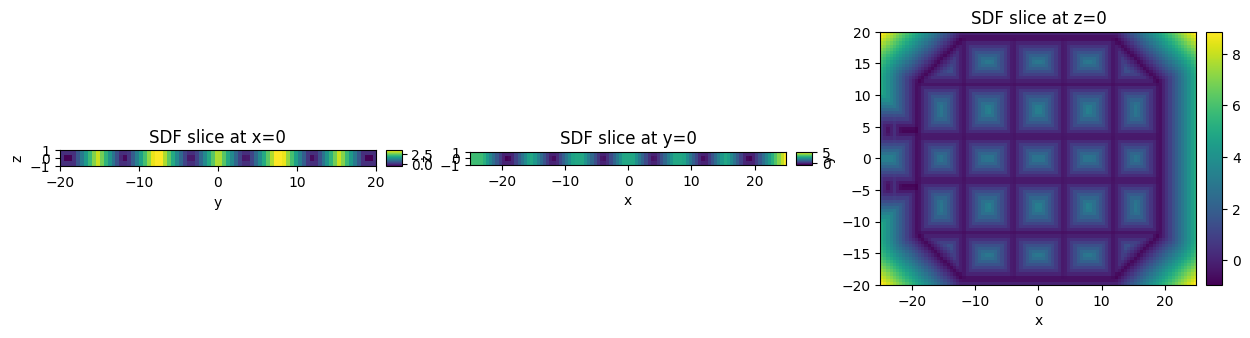

In [14]:
plot_grid(sdf_grid, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 3.466034925736494e-08, rho max: 0.9241418242454529


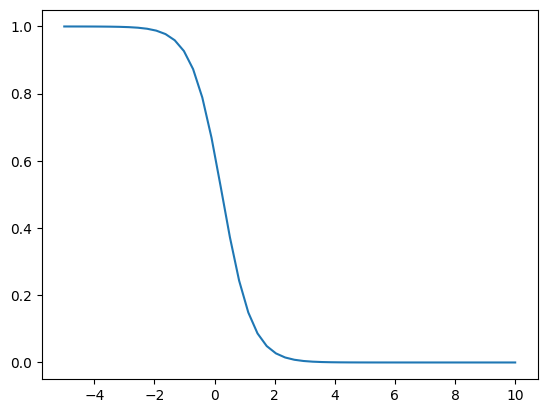

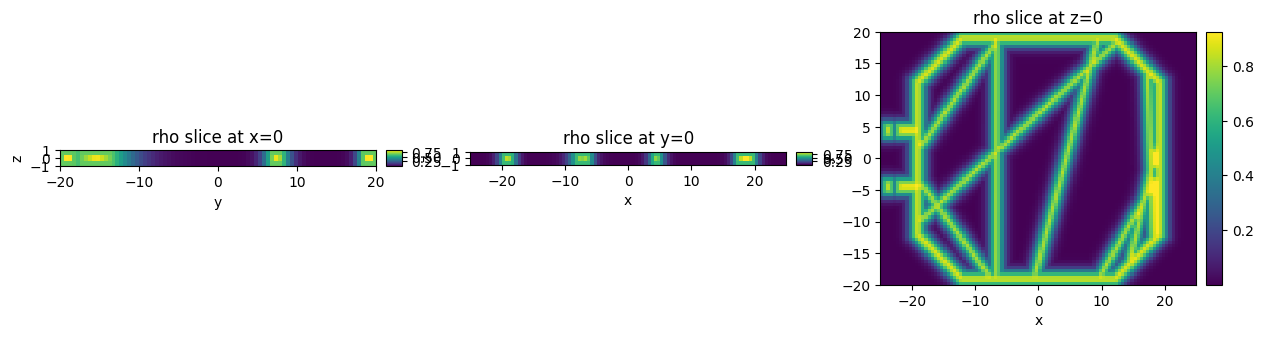

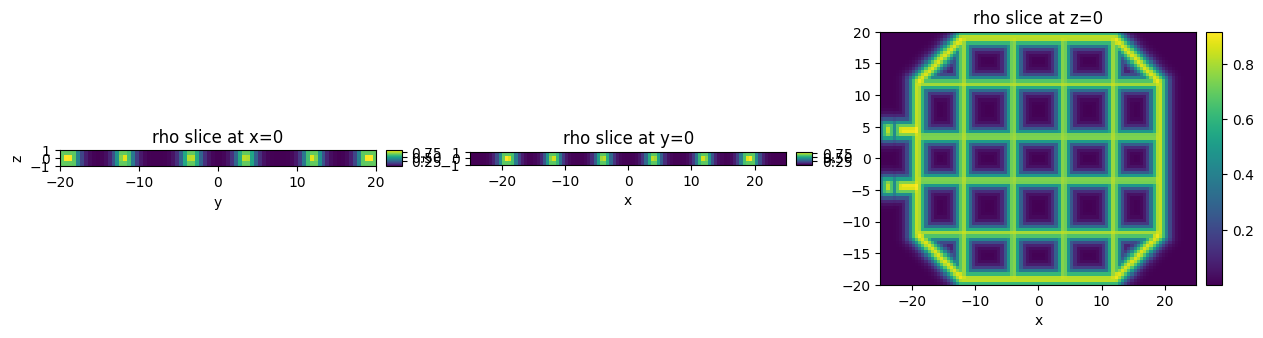

In [15]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 2
rho_offset = 0.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho_rnd = sdf_to_rho(sdf_rnd, scale=rho_scale, offset=rho_offset)
rho_grid = sdf_to_rho(sdf_grid, scale=rho_scale, offset=rho_offset)

plot_grid(rho_rnd, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
plot_grid(rho_grid, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho_rnd)}, rho max: {jnp.max(rho_rnd)}")

## Hex Mesh

As a next step, we create a hex mesh that is just a regular grid of voxel cells. Each density value is then associated with one cell in the grid.

In [16]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

We can look at the density values and the hex mesh cell center positions using a 3D scatter plot.

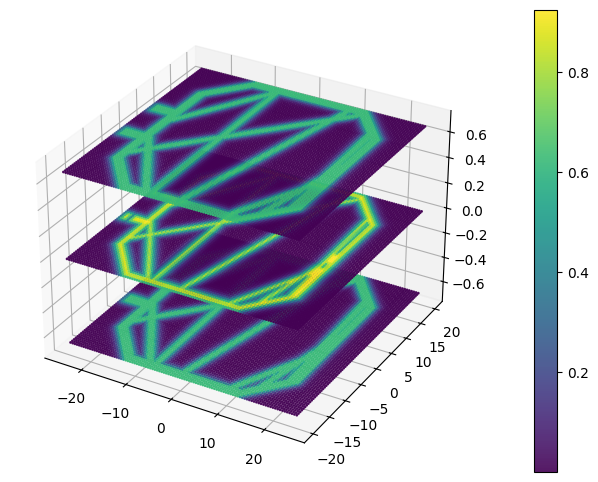

In [17]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho_rnd.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=1,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

In [ ]:
def get_boundary_masks(
    mesh: dict, Lx: float, Ly: float, Lz: float, sdf: jnp.ndarray
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.
        sdf: Signed distance field

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = jnp.logical_and(
        pts[:, 0] <= -Lx / 2 + Lx / 12, sdf.flatten() < 0.5
    )
    von_neumann_mask_1 = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 7.6, atol=Lx / 64), sdf.flatten() < 0.5
    )
    von_neumann_mask_2 = jnp.logical_and(
        jnp.isclose(pts[:, 1], (Ly / 2) - Ly / 27.6, atol=Ly / 64), sdf.flatten() < 0.5
    )
    von_neumann_mask_3 = jnp.logical_and(
        jnp.isclose(pts[:, 1], -(Ly / 2) + Ly / 27.6, atol=Ly / 64), sdf.flatten() < 0.5
    )

    von_neumann_mask = jnp.logical_or(von_neumann_mask_1, von_neumann_mask_2)
    von_neumann_mask = jnp.logical_or(von_neumann_mask, von_neumann_mask_3)

    return dirichlet_mask, von_neumann_mask


sdf_points = jnp.pad(sdf_rnd, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz, sdf_points)

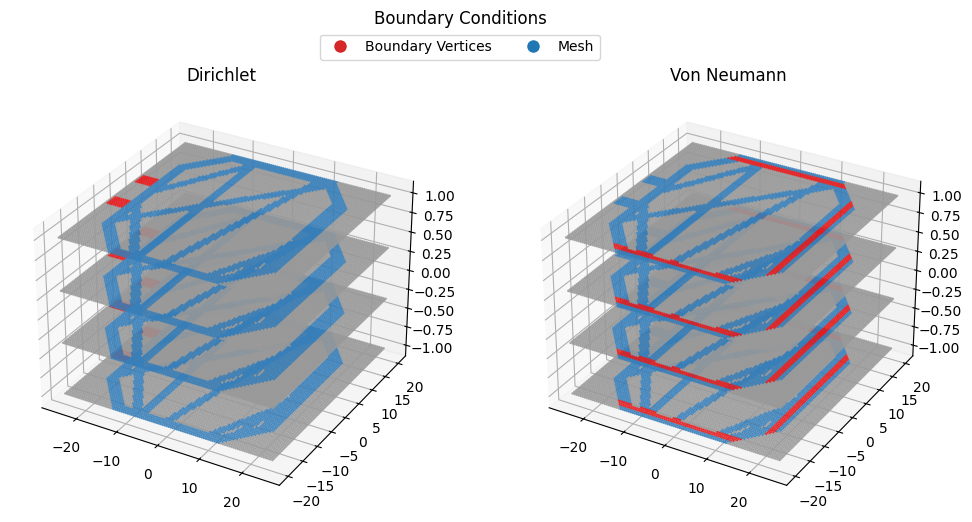

In [39]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

plt.suptitle("Boundary Conditions")

sdf_points = jnp.pad(sdf_rnd, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
base = jnp.where(sdf_points.flatten() < 0.5, 0.2, 0.6)

pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[0].set_title("Dirichlet")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[1].set_title("Von Neumann")


# Create proxy artists for the legend
neumann_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Boundary Vertices",
    markerfacecolor="tab:red",
    markersize=10,
)
base_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Mesh",
    markerfacecolor="tab:blue",
    markersize=10,
)

# Add a single legend for the figure
fig.legend(
    handles=[neumann_proxy, base_proxy],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),  # Adjust position as needed
    ncol=3,
)  # Number of columns in the legend

## Finite Element Analysis

In [40]:
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(von_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) / len(von_neumann_idx) + jnp.zeros(
    (von_neumann_idx.shape[0], 3)
)

fem_inputs = {
    "dirichlet_mask": dirichlet_idx,
    "dirichlet_values": jnp.zeros(dirichlet_idx.size),
    "van_neumann_mask": von_neumann_idx,
    "van_neumann_values": von_neumann_values,
    "hex_mesh": hex_mesh,
    "host": str(mapdl_host),
    "port": str(mapdl_port),
    "E0": 1.0,
    "rho_min": 1e-6,
    "log_level": "DEBUG",
    "vtk_output": "mesh_density.vtk",
}

Lets compute the compliance for both initial conditions.

In [41]:
fem_out_rnd = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_rnd.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance random: {fem_out_rnd['compliance']:.4f}")

Compliance random: 86.9768


In [42]:
fem_out_grid = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_grid.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance grid: {fem_out_grid['compliance']:.4f}")

Compliance grid: 61.9375


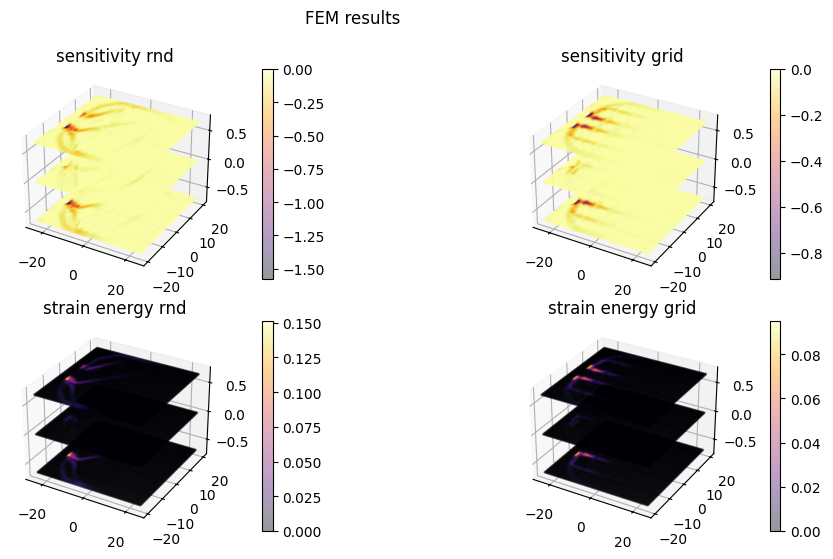

In [43]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("FEM results")

pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)

scat1 = axs[0, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_rnd["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 0].set_title("sensitivity rnd")
cbar = plt.colorbar(scat1, ax=axs[0, 0], pad=0.1)

scat2 = axs[1, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_rnd["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 0].set_title("strain energy rnd")
cbar = plt.colorbar(scat2, ax=axs[1, 0], pad=0.1)

scat1 = axs[0, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 1].set_title("sensitivity grid")
cbar = plt.colorbar(scat1, ax=axs[0, 1], pad=0.1)

scat2 = axs[1, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 1].set_title("strain energy grid")
cbar = plt.colorbar(scat2, ax=axs[1, 1], pad=0.1)

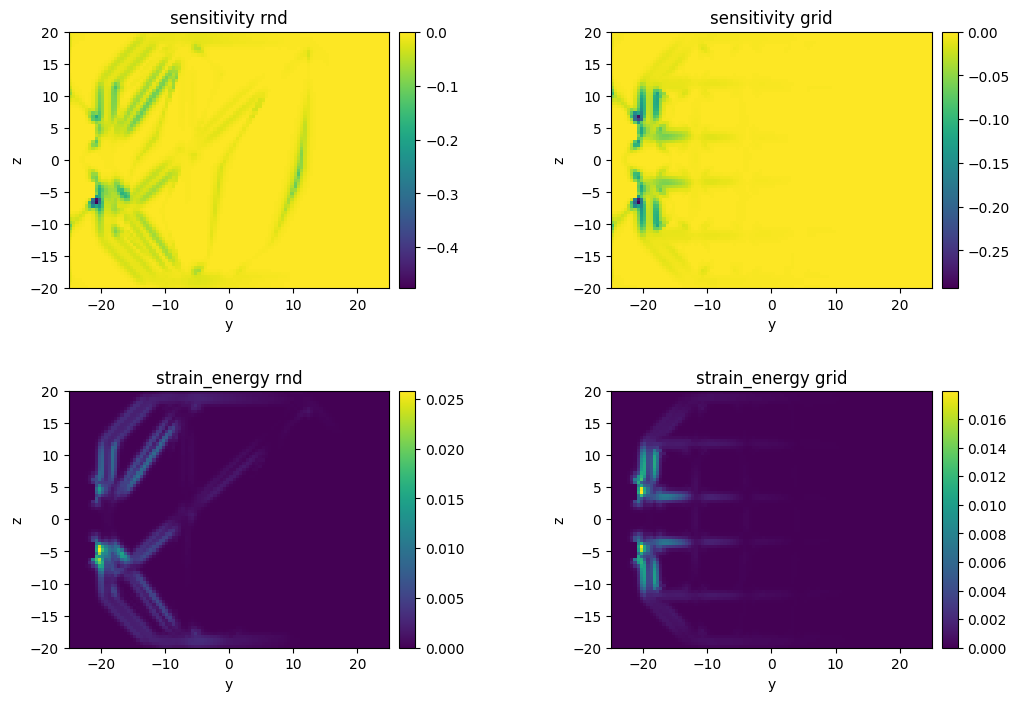

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

mesh_star = hex_mesh

pts_coords = mesh_star["points"]
hex_cells = mesh_star["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

plot_grid_slice(
    fem_out_rnd["sensitivity"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="sensitivity rnd",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_rnd["strain_energy"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="strain_energy rnd",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_grid["sensitivity"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="sensitivity grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_grid["strain_energy"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="strain_energy grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.0, hspace=0.4)

## Optimization Setup

In [45]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

    compliance = apply_tesseract(
        fem_tess,
        {"rho": jnp.expand_dims(rho.flatten(), axis=-1), **fem_inputs},
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    return compliance, {"sdf": sdf, "rho": rho, "surface_mesh": surface_mesh}


grad_fn = jax.value_and_grad(loss, has_aux=True)

## Optimization

In [ ]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
    mode: str = "mma",
) -> tuple[list, list, list]:
    """Optimize a design defined by parameters."""
    # set design bounds by a perturbation value 'delta'
    param_min = diffable_params.copy()
    param_max = diffable_params.copy()

    # the cutting planes do not change
    param_min = param_min.at[0].subtract(1.0e-3)
    param_min = param_min.at[1].subtract(1.0e-3)

    # the bars are free to rotate 2pi from their starting point
    theta_min = -2
    theta_max = 3
    for i in range(2, len(diffable_params)):
        param_min = param_min.at[i].set(theta_min)
        param_max = param_max.at[i].set(theta_max)

    # A placeholder is used for constraint
    num_constraints = 0
    g = jnp.zeros((0, 1))
    dgdx = jnp.zeros((0, diffable_params.shape[0]))

    # initialize the optimizer
    x_update_limit = 0.001  # 0.001 was okay, 0.01 was too much, 0.005 noisy but okay over 20 steps, 0
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []
    if mode == "mma":
        optimizer = MMAOptimizer(
            diffable_params[:, None],
            param_min[:, None],
            param_max[:, None],
            num_constraints,
            x_update_limit=x_update_limit,
        )
    elif mode == "adam":
        optmizer = optax.adam(learning_rate=0.01)
        opt_state = optmizer.init(params)
    else:
        raise Exception("Invalid argument.")

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)
        print(f"params: {params}")
        print(f"grads: {grads}")

        if mode == "mma":
            print("using mma")
            np_params = optimizer.calculate_next_x(
                loss_value, grads, g, dgdx, i + 1, params
            )
            params = jnp.array(np_params.flatten())

        elif mode == "adam":
            print("using adam")
            grads = grads / jnp.max(grads)
            updates, opt_state = optmizer.update(
                grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
            )
            params = optax.apply_updates(params, updates)
            params = params.at[0:2].set(diffable_params[0:2])

        print(f"params after update: {params}")
        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

We can now run an optmization on the ranomly initialized geometry. The main bottleneck of this pipeline is the SpaceClaim which has signifcant overhead slowing this optimization down by a lot. The cell can easily take 2-3 hours to finish on a powerful compute instance.

In [62]:
loss_hist_rnd_adam, params_hist_rnd_adam, aux_hist_rnd_adam = optimize(
    init_diffable_params_rnd, iterations=60, mode="adam"
)

params: [0.2        0.2        0.94814765 0.97907615 0.33246002 0.46890613
 0.57017773 0.16558696 0.31035194 0.68983024 0.7471453  0.17110129
 0.98585355 0.02529544 0.64036644 0.56297624 0.8996699  0.93501145]
grads: [ 3.1508258e+02  2.7326174e+00  1.0713361e-01 -5.8232013e-02
  4.7479755e+01  4.0011925e+01  1.8601865e+02  6.2557800e+01
 -3.7841274e+01  3.0999165e+01  1.0834747e+01 -9.2259626e+00
 -8.2135297e-02 -5.9810925e-01 -2.5272890e+01  6.7943115e+01
  9.9145991e-01  6.5390992e-01]
using adam
params after update: [0.2        0.2        0.938148   0.98907554 0.3224601  0.4589062
 0.5601778  0.15558703 0.32035187 0.6798303  0.73714536 0.18110122
 0.9958531  0.03529532 0.65036637 0.5529763  0.88967    0.9250116 ]
Iteration 1, Loss: 86.9768
params: [0.2        0.2        0.938148   0.98907554 0.3224601  0.4589062
 0.5601778  0.15558703 0.32035187 0.6798303  0.73714536 0.18110122
 0.9958531  0.03529532 0.65036637 0.5529763  0.88967    0.9250116 ]
grads: [ 3.0431171e+02  5.1260262e+00 

Lets do the same on the grid ICs.

In [66]:
loss_hist_grid_adam, params_hist_grid_adam, aux_hist_grid_adam = optimize(
    init_diffable_params_grid, iterations=60, mode="adam"
)

params: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.88430935 0.6164513 ]
grads: [ 247.17923       6.7173285    -3.7711732     3.539281     -7.516162
    5.6876364     0.53856695   -5.894492     21.43473     -29.410927
    2.5403214    -1.0929871    11.789357   -205.96976      -6.1246796
  -12.429398     -3.624876    176.88391   ]
using adam
params after update: [0.2        0.2        0.14392893 0.8565782  0.22444198 0.7760652
 0.27581164 0.72469556 0.35632464 0.6441825  0.02143268 0.4788209
 0.10619786 0.39405572 0.9790745  0.5416861  0.8943093  0.6064514 ]
Iteration 1, Loss: 61.9375
params: [0.2        0.2        0.14392893 0.8565782  0.22444198 0.7760652
 0.27581164 0.72469556 0.35632464 0.6441825  0.02143268 0.4788209
 0.10619786 0.39405572 0.9790745  0.5416861  0.8943093  0.6064514 ]
grads: [ 244.96892       0.52629995   -1.0218668     0.36024344  -1

We can now compare the loss values over the course of the optimization for the two ICs. Interestingly they both seem to converge to a similar compliance.

Text(0.5, 1.0, 'Compliance over Optimization using adam')

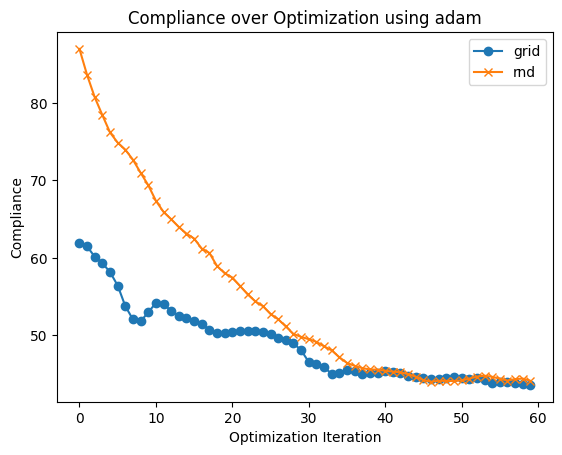

In [ ]:
plt.plot(loss_hist_grid_adam, marker="o", label="grid")
plt.plot(loss_hist_rnd_adam, marker="x", label="rnd")
plt.legend()
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization using adam")

### Optimization Postprocess

In order to visualize the optmization, we generate two gifs showing the evolution of the surface mesh. We start with the grid optimization, followed by the random optimization.

In [ ]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist_grid_adam):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(len(aux_hist_grid_adam)):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("imgs/mesh_grid_adam.gif", images, fps=10, loop=0)

/tmp/ipykernel_13978/3906708532.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.
Added tmp_img/mesh_optim_016.png to gif.
Added tmp_img/mesh_optim_017.png to gif.
Added tmp_img/mesh_optim_018.png to gif.
Added tmp_img/mesh_optim_019.png to gif.
Added tmp_img/mesh_optim_020.png to gif.
Added tmp_img/mesh_optim_021.png to gif.
Added tmp_img/mesh_optim_022.png to gif.
Added tmp_img/mesh_optim_023.png to gif.
Added tmp_img/me

In [ ]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist_rnd_adam):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(len(aux_hist_rnd_adam)):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("imgs/mesh_rnd_adam.gif", images, fps=10, loop=0)

/tmp/ipykernel_13978/2861389473.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.
Added tmp_img/mesh_optim_016.png to gif.
Added tmp_img/mesh_optim_017.png to gif.
Added tmp_img/mesh_optim_018.png to gif.
Added tmp_img/mesh_optim_019.png to gif.
Added tmp_img/mesh_optim_020.png to gif.
Added tmp_img/mesh_optim_021.png to gif.
Added tmp_img/mesh_optim_022.png to gif.
Added tmp_img/mesh_optim_023.png to gif.
Added tmp_img/me

We can now visually compare the two optimization runs.

| Grid IC | Random IC |
|----------|----------|
| ![Workflow](imgs/mesh_grid_adam.gif)    | ![Workflow](imgs/mesh_rnd_adam.gif)     |


Both runs converge to similar non symmetric solutions. It is likely that a more symmetric solution could be reached when executing the optimization for more iterations, however an even better approach would be to add symmetry constraints on the parameters.

In both cases, the optimizer deposits a lot of material near the left side of the geometry to increase the stiffness of the part there. This is also reflected by the strain energy plots, where the part experiences significantly more strain closer to the fixed Dirichlet boundary conditions. Furthermore we can notice a similar pattern as the grid like structure emerging from the random initial conditions, hinting towards a globally optimal solution.